In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [2]:
DEBUG = True

In [3]:
def calibrate_camera():
    calibration_images = []
    imgpoints = []
    objpoints = []
    objp_grid = []

    for x in range(9):
        for y in range(6):
            objp_grid.append([[x,y,0]])
    for f in glob.glob("./camera_cal/*jpg"):
        img = cv2.imread(f)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray,(9,6), None)
        if ret == True:
            cv2.drawChessboardCorners(img, (9, 6), corners, ret)
            if DEBUG:
                plt.figure(figsize=(10,5))
                plt.title(f)
                plt.imshow(img)
                plt.show()
            imgpoints.append(corners)
            objpoints.append(objp_grid)
    imgpoints = np.array(imgpoints, dtype=np.float32)
    objpoints = np.array(objpoints, dtype=np.float32)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints,(1280,720),None, None)
    
    if DEBUG:
        print(imgpoints[0].shape, objpoints[0].shape)
        print(imgpoints.shape, objpoints.shape)
    
    return mtx, dist

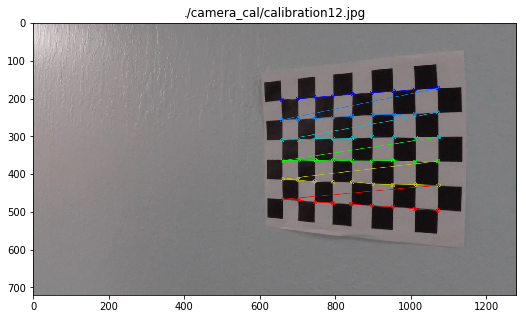

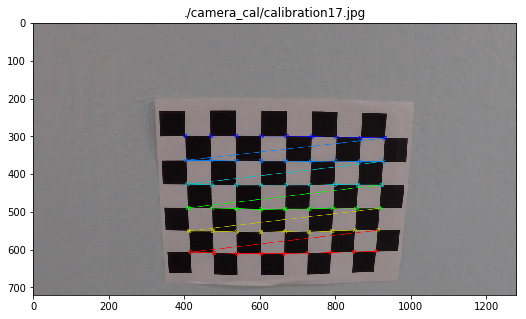

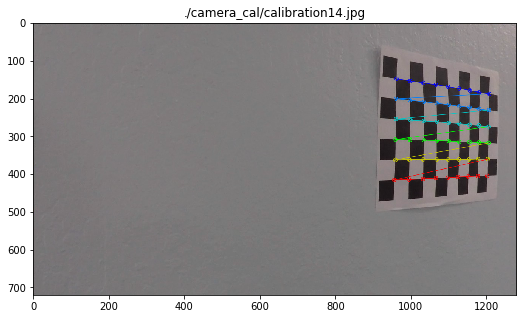

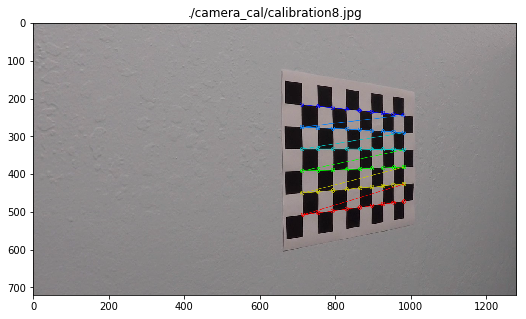

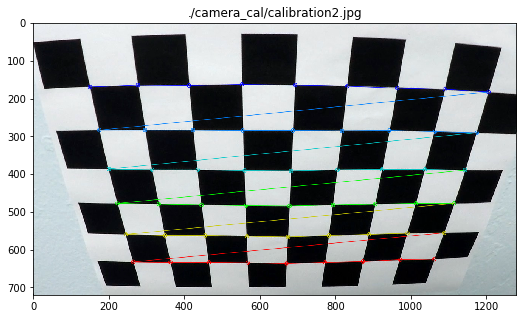

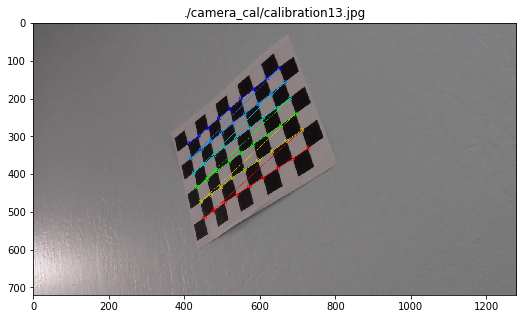

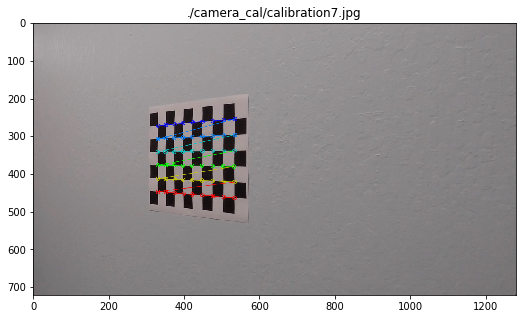

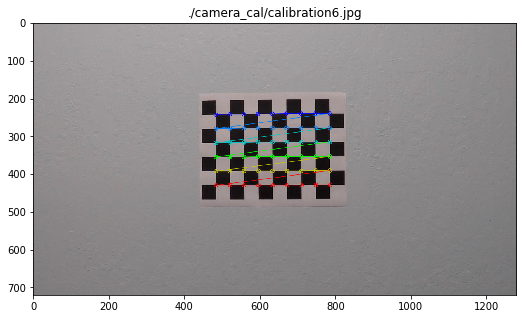

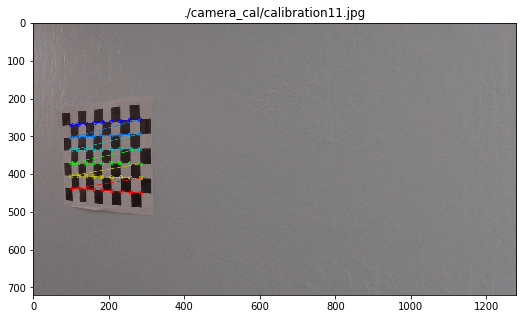

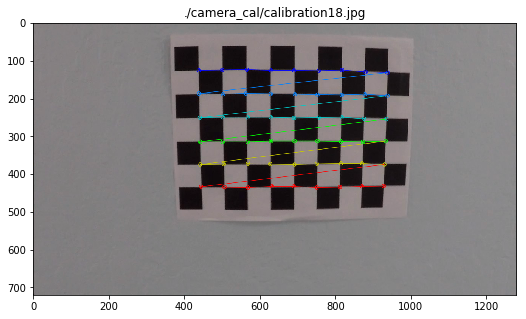

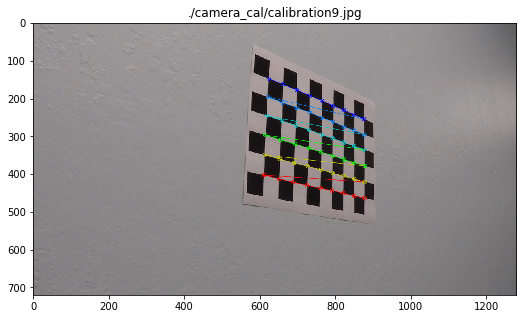

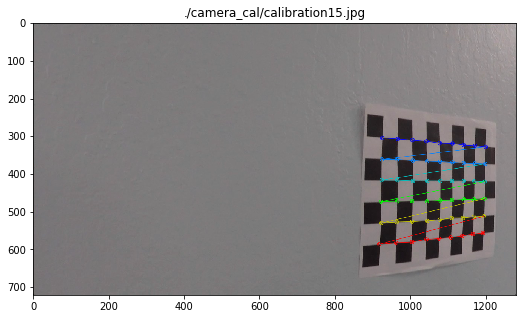

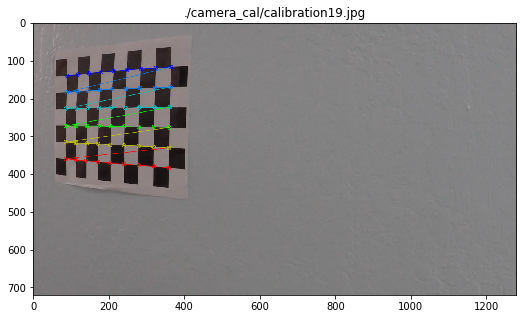

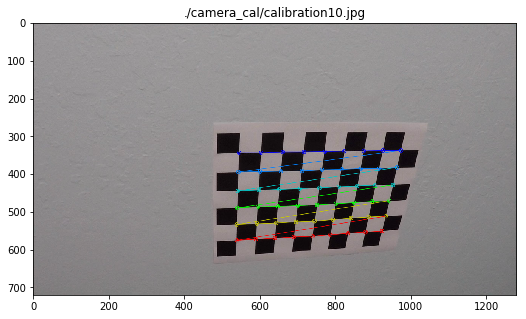

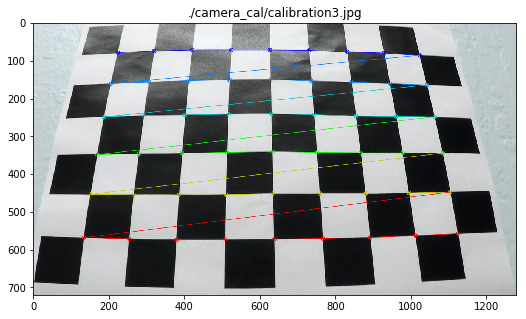

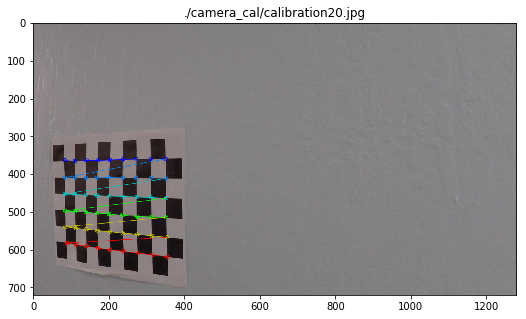

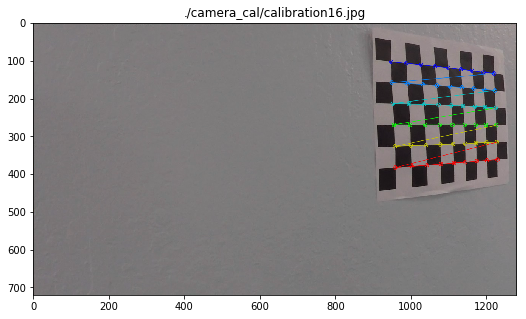

(54, 1, 2) (54, 1, 3)
(17, 54, 1, 2) (17, 54, 1, 3)


In [3]:
mtx, dist = calibrate_camera()

(720, 1280, 3)


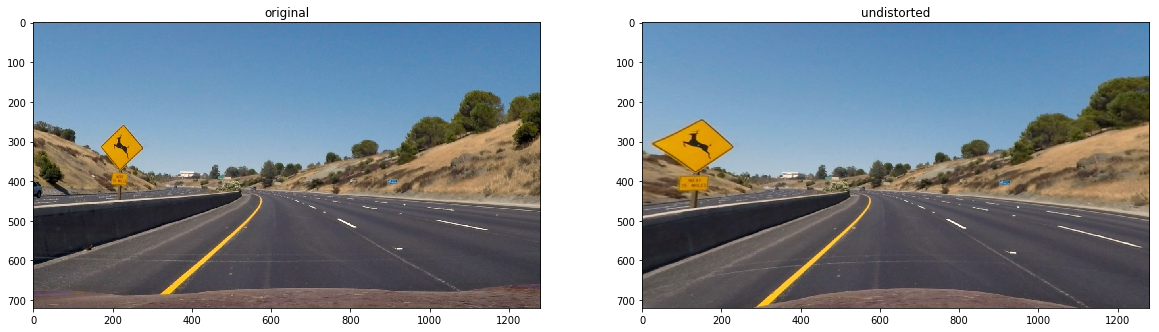

In [4]:
img = cv2.imread("./test_images/test2.jpg")
undist = cv2.undistort(img, mtx, dist, None, mtx)
fig ,(ax1, ax2) = plt.subplots(1,2,figsize=(20,20))
ax1.set_title("original")
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax2.set_title("undistorted")
ax2.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
print(undist.shape)

In [7]:
def calc_s_chan_thresholds(undist):
    hls = cv2.cvtColor(undist, cv2.COLOR_BGR2HLS)
    s_chan = hls[:,:,2]
    binary_s = np.zeros_like(s_chan)
    binary_s[(s_chan > 180) & (s_chan < 235)] = 1

    if DEBUG:
        h_chan = hls[:,:,0]
        l_chan = hls[:,:,1]

        f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,10))
        ax1.set_title("h_channel")
        ax1.imshow(h_chan, cmap="gray")
        ax2.set_title("l_channel")
        ax2.imshow(l_chan, cmap="gray")
        ax3.set_title("s_channel")
        ax3.imshow(s_chan, cmap="gray")
        mpimg.imsave("h_chan", h_chan, cmap="gray")
        mpimg.imsave("s_chan", s_chan, cmap="gray")
        binary_h = np.zeros_like(h_chan)
        binary_h[(h_chan < 50)] = 1

        mpimg.imsave("s_thresholded", binary_s, cmap="gray")
        f, (ax2) = plt.subplots(1,1,figsize=(15,10))
        ax2.set_title("thresholded s channel")
        ax2.imshow(binary_s, cmap="gray")

    return binary_s

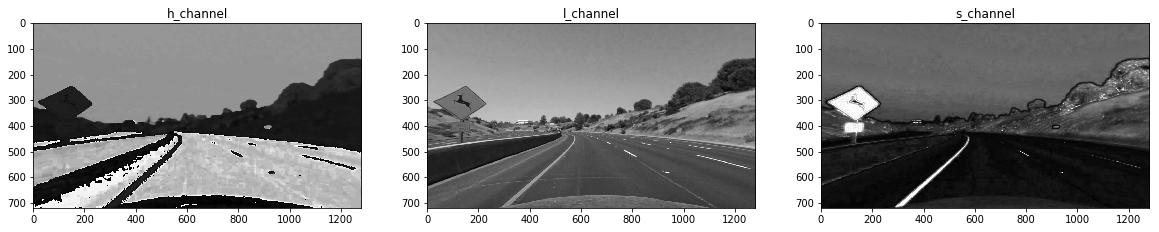

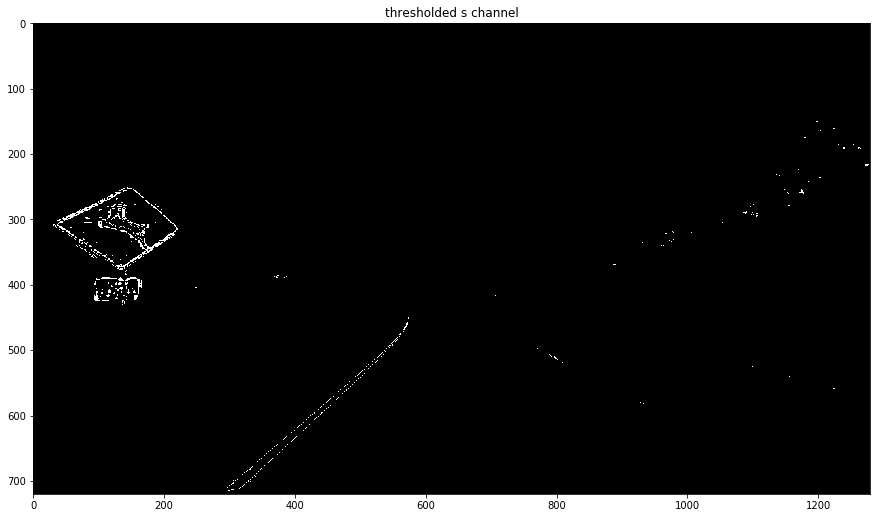

In [6]:
binary_s = calc_s_chan_thresholds(undist)

In [8]:
def calc_sobel_thresholds(gray):
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    sobelmag = np.sqrt(sobelx*sobelx + sobely*sobely)
    scaled_sobelmag = np.uint8(sobelmag*255/np.max(sobelmag))
    sobelmag_thresh = np.zeros_like(scaled_sobelmag, dtype=np.float32)
    sobelmag_thresh[(scaled_sobelmag > 50)] = 1
    
    sobeldir = np.arctan2(abs_sobely, abs_sobelx)
    sobeldir_thresh = np.zeros_like(sobeldir, dtype=np.float32)
    sobeldir_thresh[(sobeldir > 0.45) & (sobeldir < 1.35)] = 1
    
    sobel_combo = np.zeros_like(gray, dtype=np.float32)
    sobel_combo[(sobeldir_thresh == 1) & (sobelmag_thresh == 1)] = 1
    
    if DEBUG:
        plt.figure(figsize=(15,10))
        plt.imshow(gray, cmap="gray")
        plt.title("gray input")
        plt.show()

        f, ax = plt.subplots(2,2,figsize=(15,10))

        scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
        ax[0][0].imshow(scaled_sobelx, cmap="gray")

        scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
        ax[0][1].imshow(scaled_sobely, cmap="gray")    

        ax[1][0].imshow(sobelmag_thresh, cmap="gray")   
        ax[1][1].imshow(sobeldir_thresh, cmap="gray")
        mpimg.imsave("sobel_mag", scaled_sobelmag, cmap="gray")
        mpimg.imsave("sobel_dir", sobeldir, cmap="gray")
        mpimg.imsave("sobel_combo", sobel_combo, cmap="gray")
        plt.figure(figsize=(15,10))
        plt.imshow(sobel_combo, cmap="gray")
        plt.show()
    return sobel_combo

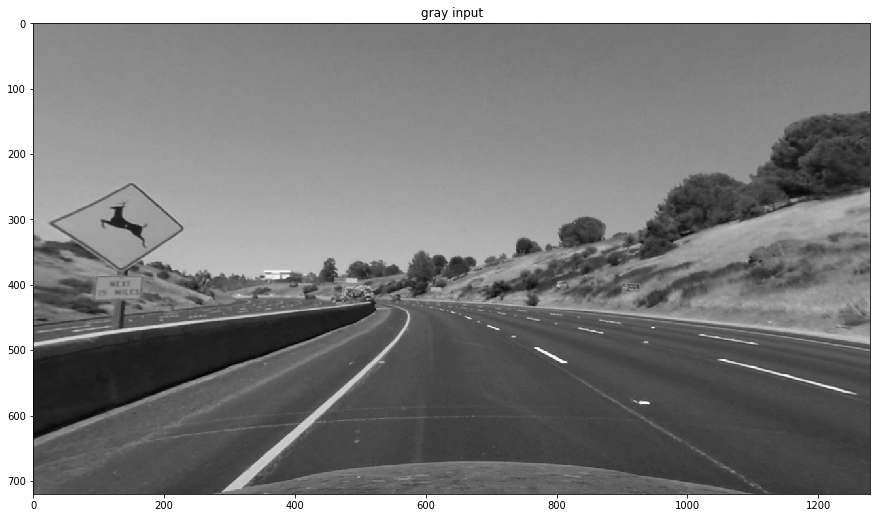

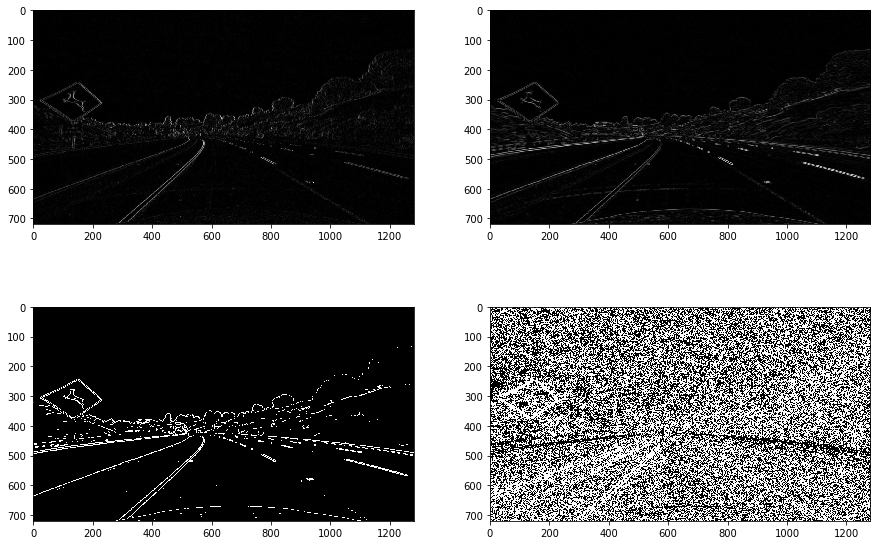

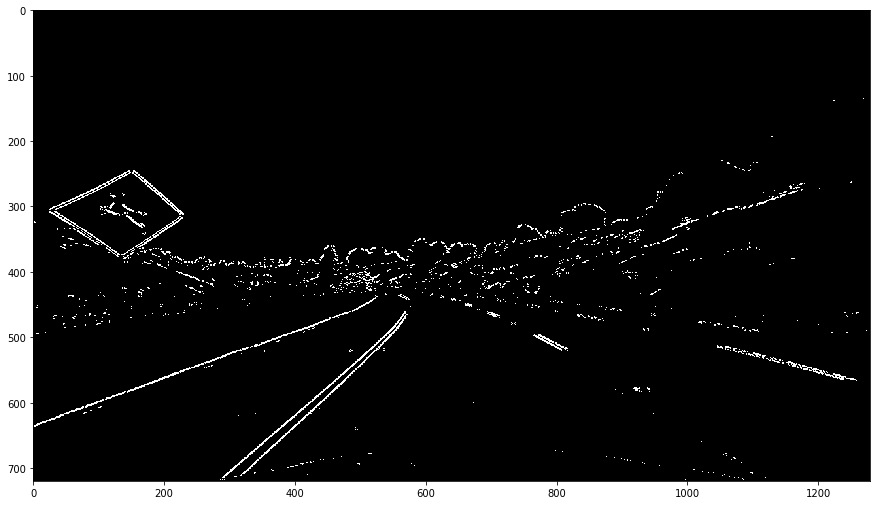

In [8]:
gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)    
sobel_combo = calc_sobel_thresholds(gray)

In [9]:
def combine_color_gradient(gray, sobel, s_chan):
    combo = np.zeros_like(gray)
    combo[(sobel == 1) | (s_chan == 1)] = 1
    
    if DEBUG:
        _, (ax1,ax2) = plt.subplots(2,1,figsize=(10,10))
        color_stack = np.stack((sobel, s_chan, np.zeros_like(sobel)), axis=2).astype(np.float32)

        ax1.imshow(color_stack)
        ax1.set_title("Thresholds RED:sobel GREEN:S-channel")

        ax2.imshow(combo, cmap="gray")
        ax2.set_title("binary out")
        mpimg.imsave("combo", combo, cmap="gray")
    return combo

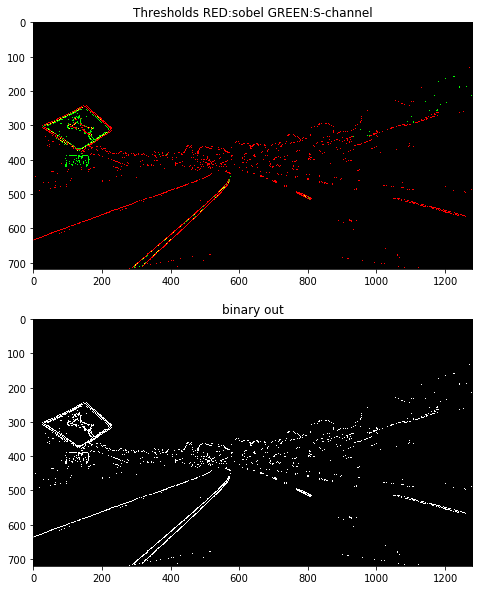

In [10]:
combo = combine_color_gradient(gray, sobel_combo, binary_s)

In [10]:
def get_perspective_transform():
    src = np.float32([[325,650],[990,650],[420,580],[880,580]])
    dst = np.float32([[300,670],[1000,670],[300,600],[993,600]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    if DEBUG:
        tx_img = mpimg.imread("test_images/straight_lines2.jpg")
        width = tx_img.shape[1]
        height = tx_img.shape[0]
        warped = cv2.warpPerspective(tx_img, M, (width,height), flags=cv2.INTER_LINEAR)
        print(width, height)
        f, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))
        ax1.imshow(tx_img)
        ax1.plot(325,650,"X")
        ax1.plot(990,650,"X")
        ax1.plot(420,580,"X")
        ax1.plot(880,580,"X")
        ax2.imshow(warped)
        plt.show()

    return M, Minv

1280 720


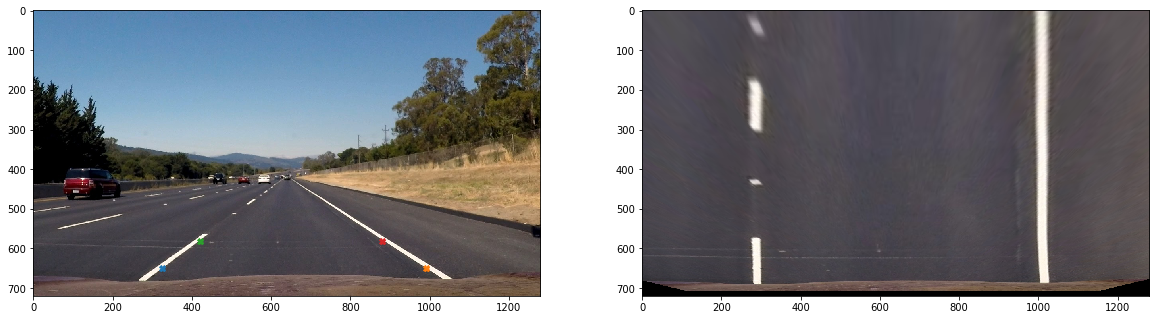

In [12]:
M, Minv = get_perspective_transform()

In [11]:
def transform_perspective(img, M):
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    
    if DEBUG:
        _, (ax1, ax2) = plt.subplots(1,2, figsize=(30,20))
        ax1.imshow(img, cmap="gray")

        ax2.imshow(warped, cmap="gray")
        plt.show()
        
    return warped

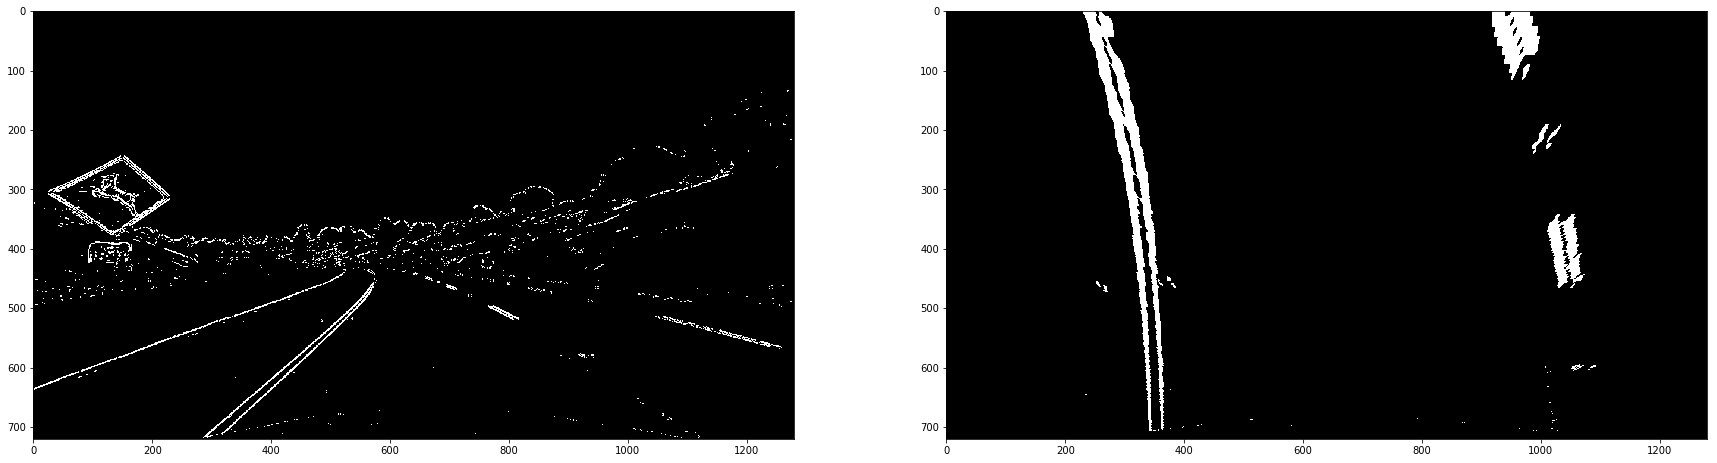

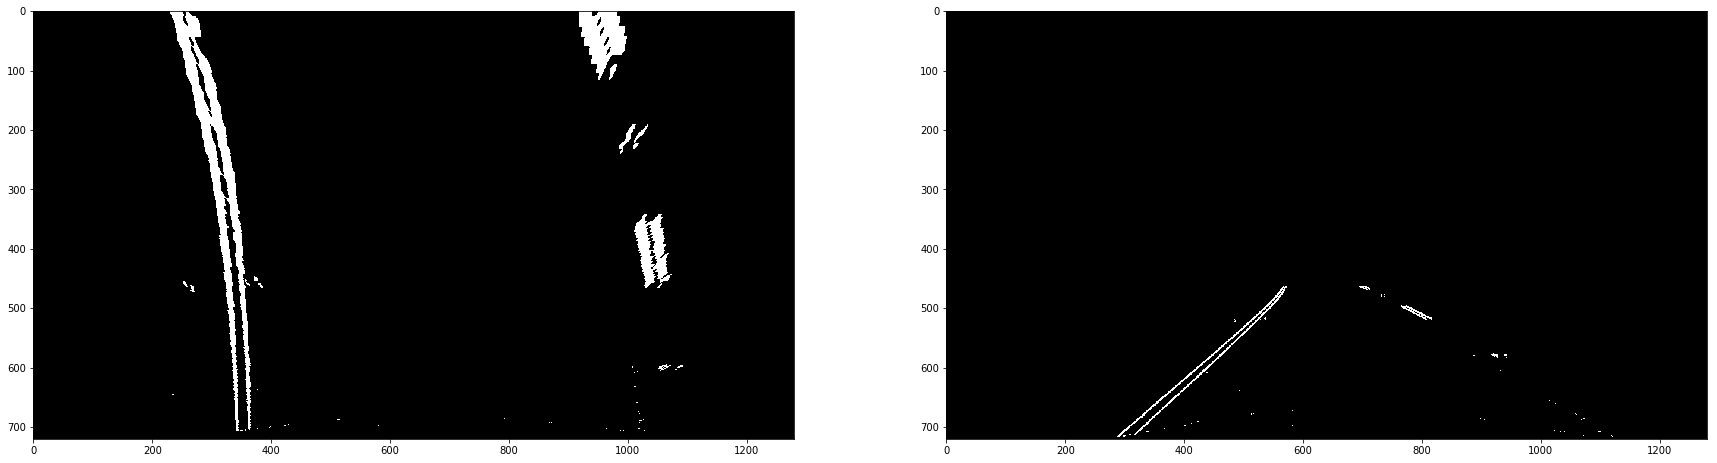

In [14]:
warped = transform_perspective(combo, M)
_ = transform_perspective(warped, Minv)

In [73]:
class Line:
    past_coeffs= [] #last 10 frames
    past_coeffs_avg = []
    past_measured = [] #last x values
    roc = 0.0
    curr_fit_x = []
    curr_fit_y = []
    dist = 0.0
    
    def __init__(self):
        past_coeffs= [] #last 10 frames
        past_coeffs_avg = []
        past_measured = [] #last x values
        roc = 0.0
        curr_fit_x = []
        curr_fit_y = []
        dist = 0.0

k = 50 # filter size k x k
x_step = 10  #slide from left to right
y_step = -30 #slide from bottom to top
        
# rejecting lane points which are too far away from the previous detected point
# assume the first detection is correct
# needs better algorithm!!!
margin_x = 80  

# rejecting lane points when there aren't at least 400 points in a 50x50 block
threshold_conv = 400        

In [47]:
def draw_rectangle(img, center, w=50, h=50):
    #print(center[0]-h//2, center[0]-h//2+1, center[1]-w//2,center[1]+w//2 )
    img[center[0]-h//2 -2:center[0]-h//2 +2, center[1]-w//2:center[1]+w//2] = [1,0.5,0]
    img[center[0]+h//2 -2:center[0]+h//2 +2, center[1]-w//2:center[1]+w//2] = [1,0.5,0]
    img[center[0]-h//2:center[0]+h//2, center[1]-w//2 -2:center[1]-w//2 +2] = [1,0.5,0]
    img[center[0]-h//2:center[0]+h//2, center[1]+w//2 -2:center[1]+w//2 +2] = [1,0.5,0]
    return

def calc_roc(yp, xp):
    ym_per_pix = 30/750  # meters per pixel in y dimension
    xm_per_pix = 3.7/750 # meters per pixel in x dimension
    y_eval = 449
    # Fit new polynomials to x,y in world space
    fit_cr  = np.polyfit(yp*ym_per_pix, xp*xm_per_pix, 2)
    # Calculate the new radii of curvature
    curverad =  ((1 + (2*fit_cr[0] *y_eval*ym_per_pix + fit_cr[1]) **2)**1.5)/np.absolute(2*fit_cr[0])
    return curverad

def draw_histogram(img):
    plt.bar(np.arange(img.shape[1]),np.sum(img, axis=0))
    plt.title("sum of pixel values across y-axis")
    plt.show() 

#fit a 2nd order polynomial to go through the detected points, one for each left and right lanes    
def fit_poly(img, detected_pts, line, poly_order=2):
    yp = np.linspace(0, img.shape[0]-1, img.shape[0])
    measured = np.polyfit(detected_pts[:,0], detected_pts[:,1], poly_order)
    l = len(line.past_coeffs)
    if l == 0:
        #print('B len={}:measured={} average={} past={}'.format(l, measured, line.past_coeffs_avg ,line.past_coeffs))      
        line.past_coeffs = np.array([measured])
        line.past_measured = np.array([measured])
        coeffs = measured
        avg = np.average(line.past_coeffs, axis=0)
        line.past_coeffs_avg = avg
        #print('A len={}:measured={} average={} past={}'.format(l, measured, line.past_coeffs_avg ,line.past_coeffs))      
    elif line.past_coeffs.shape[0] < 5:
        #print('B2:measured={} average={} past={}'.format(measured, line.past_coeffs_avg ,line.past_coeffs))
        line.past_coeffs = np.concatenate((line.past_coeffs, [measured]), axis=0)
        line.past_measured = np.concatenate((line.past_measured, [measured]), axis=0)
        coeffs = measured
        avg = np.average(line.past_coeffs, axis=0)
        line.past_coeffs_avg = avg
        #print('A2:measured={} average={} past={}'.format(measured, line.past_coeffs_avg,line.past_coeffs))
    else:
        #prev_avg = line.past_coeffs_avg
        #diff = np.sum(np.abs((measured - prev_avg)/(measured.shape[0]*prev_avg)), axis=0)
        #print('B3:diff={} measured={} average={} past={}'.format(diff,measured, line.past_coeffs_avg,line.past_coeffs))        
        sd_past_measured = np.std(line.past_measured, axis=0)
        mean_past_measured = np.mean(line.past_measured, axis=0)
        if np.any(np.abs(measured-mean_past_measured) > 1.3*sd_past_measured):
            coeffs = line.past_coeffs_avg
        else:
            coeffs = measured*0.35 + line.past_coeffs_avg*0.65

        line.past_measured = np.concatenate((line.past_measured[-29:], [measured]), axis=0)
        line.past_coeffs = np.concatenate((line.past_coeffs[-9:], [coeffs]), axis=0)
        line.past_coeffs_avg = np.average(line.past_coeffs, axis=0)     
    
    fit_left = np.poly1d(coeffs)
    xp = fit_left(yp)
    return coeffs, yp, xp

In [94]:
def detect_lanes(img, left, right):
    detected_left = [] # left lane points
    detected_right = [] # right lane points
    f = np.ones((k,k))
    global frame_count
    
    strip = img[-600:,15:-15]

    if DEBUG:
        draw_histogram(strip)
        color_img = cv2.cvtColor(strip.astype(np.float32), cv2.COLOR_GRAY2RGB)    
        _, (ax1, ax2) = plt.subplots(2,1, figsize=(20,10))
        ax1.imshow(strip, cmap="gray")

    for y in range(strip.shape[0], 0, y_step):
        conv_left_max = 0
        conv_right_max = 0
        for x in range(0, strip.shape[1], x_step):
            conv = np.sum(np.multiply(f[:(strip[y-k:y,x:x+k].shape[0]),:(strip[y-k:y,x:x+k].shape[1])], strip[y-k:y,x:x+k]))
            
            if conv < threshold_conv: #choose only points beyond a certain threshold
                continue

            if x < strip.shape[1]/2: #assuming the car is at the center of the lane
                if conv > conv_left_max: #choose the best point along x-axis
                    if len(detected_left) > 0 and (abs(detected_left[-1:][0][1] - (x+k/2)) > margin_x):
                        continue
                    conv_left_max = conv
                    cord_left_max = [y-k//2,x+k//2]
            else:
                if conv > conv_right_max: #choose only the best point along x-axis 
                    if len(detected_right) > 0 and (abs(detected_right[-1:][0][1] -(x+k/2)) > margin_x):
                        continue
                    conv_right_max = conv
                    cord_right_max = [y-k//2, x+k//2]
        
        #for each horizontal search,
        #  select only the best point on each left and right side. 
        #  append that point to a list
        if conv_left_max > 0:
            detected_left.append(cord_left_max)
            if DEBUG:
                ax2.plot(cord_left_max[1], cord_left_max[0],"X")
                draw_rectangle(color_img, cord_left_max, 50, 50)
            
        if conv_right_max > 0:
            detected_right.append(cord_right_max)
            if DEBUG:
                draw_rectangle(color_img, cord_right_max, 50, 50)
                ax2.plot(cord_right_max[1], cord_right_max[0],"X")
    
    #Check if the frame has at least one point detected on the left side
    if len(detected_left) > 0: 
        detected_left = np.array(detected_left)
        left_coeffs, yp, xp_left =  fit_poly(img, detected_left,left)
        #print("left coeffs", left_coeffs)
        left.roc = calc_roc(yp, xp_left)
        left.curr_fit_x = xp_left
        left.curr_fit_y = yp
        if DEBUG:
            ax2.plot(xp_left,yp,"b-",linewidth=5)
            ax2.text(350,50,'radius of curvature left={:.2f}'.format(left.roc),color="white")
    else:
        print("ERROR: no left lane detected")
        cv2.imwrite('left_{}.jpg'.format(i), cv2.cvtColor(img, cv2.COLOR_GRAY2BGR))
    #Check if the frame has at least one point detected on the right    
    if len(detected_right) > 0:
        detected_right = np.array(detected_right)
        right_coeffs, yp, xp_right = fit_poly(img, detected_right,right)
        #print("right coeffs", right_coeffs)
        right.roc = calc_roc(yp, xp_right)
        right.curr_fit_x = xp_right   
        right.curr_fit_y = yp
        if DEBUG:
            ax2.plot(xp_right,yp,"b-",linewidth=5)
            ax2.text(350,100,'radius of curvature right={:.2f}'.format(right.roc),color="white")
    else:
        print("ERROR: no right lane detected")  
        cv2.imwrite('right_{}.jpg'.format(i), cv2.cvtColor(img, cv2.COLOR_GRAY2BGR))
        
    left.dist = ((right.curr_fit_x[-1]+left.curr_fit_x[-1])/2.0 - strip.shape[1]/2.0)*3.7/750.0
    right.dist = left.dist
    if DEBUG:
        ax2.imshow(color_img)
        plt.show()
            
    frame_count +=1 
    return left, right

In [18]:
left = Line()
right = Line()
left, right = detect_lanes(warped, left, right)

None


In [83]:
# Create an image to draw the lines on
def paint_lane(warped, undist, left, right):
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left.curr_fit_x, left.curr_fit_y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right.curr_fit_x, right.curr_fit_y])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (warped.shape[1], warped.shape[0])) 
    # Combine the result with the original image

    #undist_rgb = cv2.cvtColor(undist, cv2.COLOR_BGR2RGB)
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,'roc: left={:.2f} right={:.2f}'.format(left.roc,right.roc),(420,70), font,1,(255,255,255))
    cv2.putText(result,'off-centre: {:.2f}m'.format(left.dist),(450,120), font,1,(255,255,255))

                #,2,cv2.LINE_AA)
    
    return result

In [ ]:
plt.imshow(cv2.cvtColor(paint_lane(warped, undist, left, right), cv2.COLOR_BGR2RGB))

In [18]:
def process_image(img):
    global left
    global right
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    binary_s = calc_s_chan_thresholds(undist)
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)    
    sobel_combo = calc_sobel_thresholds(gray)
    combo = combine_color_gradient(gray, sobel_combo, binary_s)
    warped = transform_perspective(combo, M)
    _ = transform_perspective(warped, Minv)
    left, right = detect_lanes(warped, left, right)
    result = paint_lane(warped, undist, left, right)
    return result

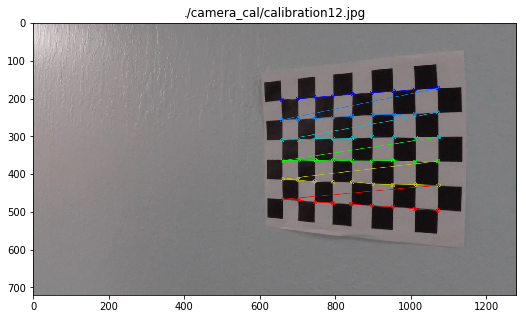

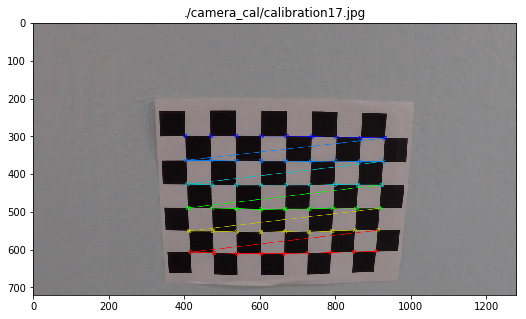

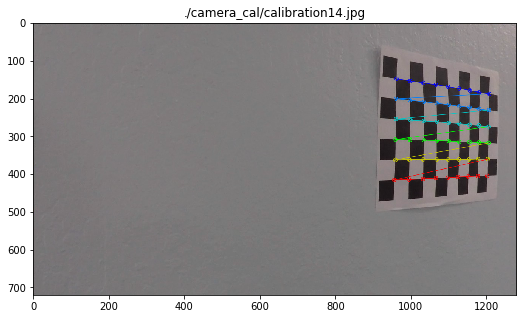

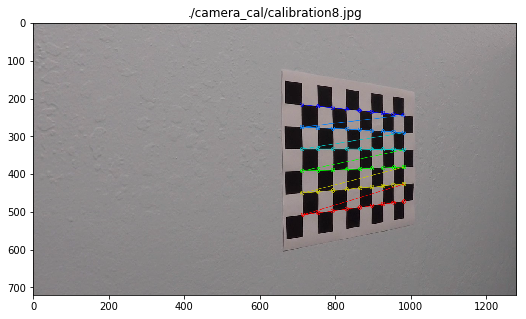

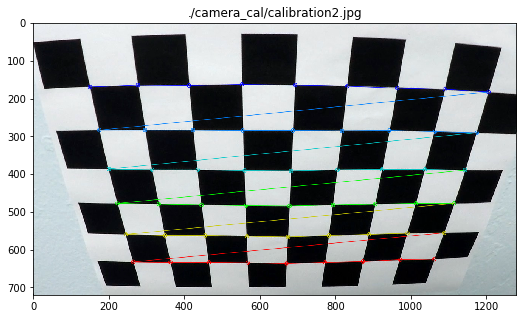

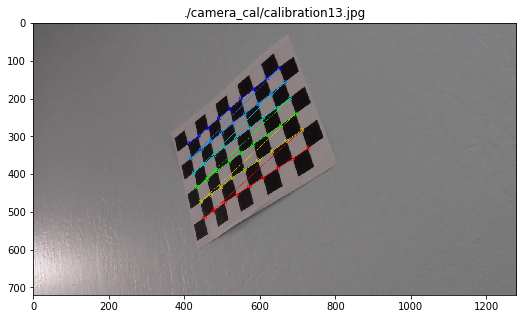

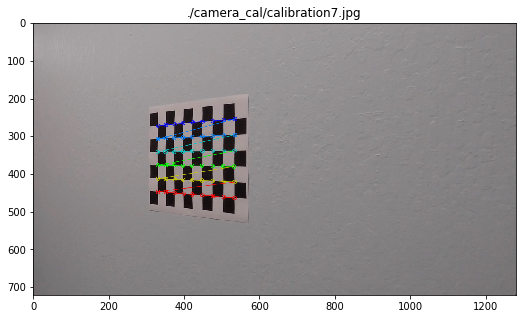

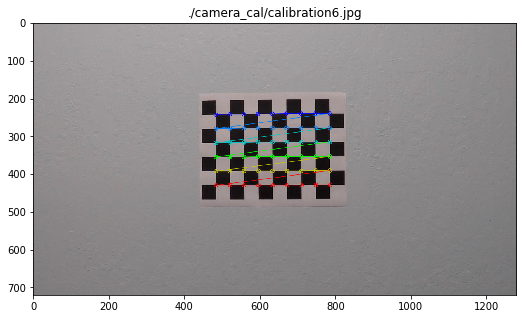

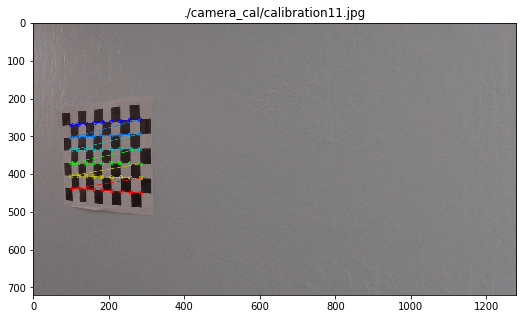

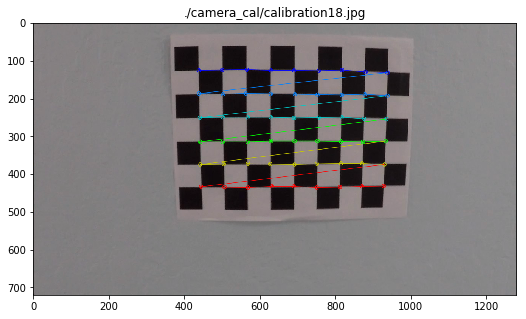

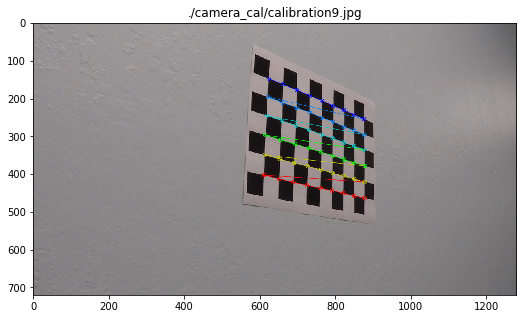

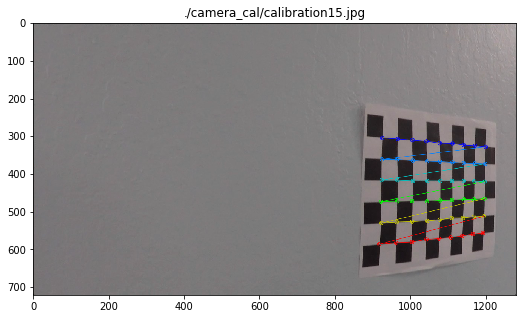

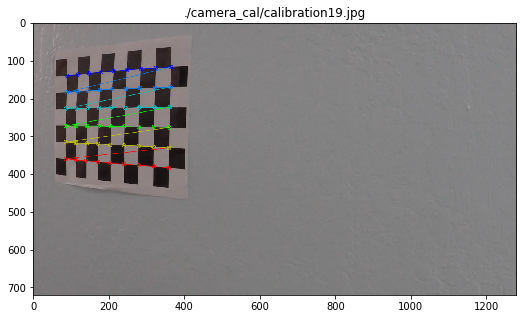

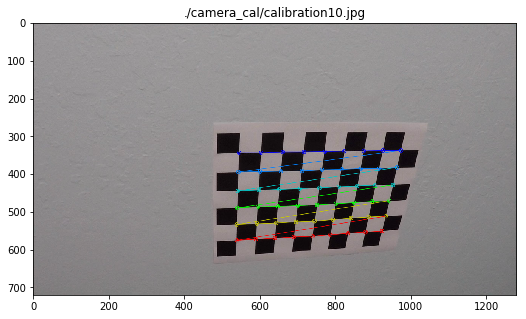

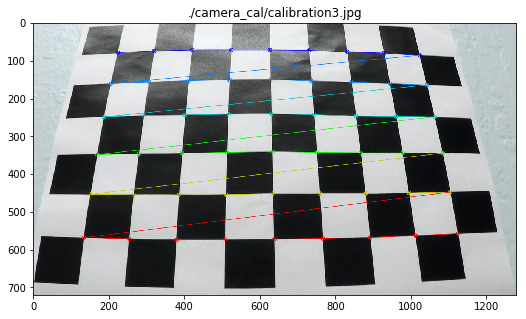

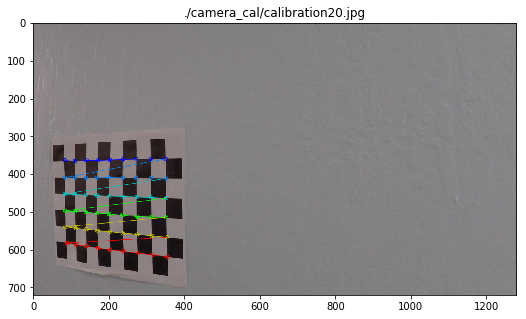

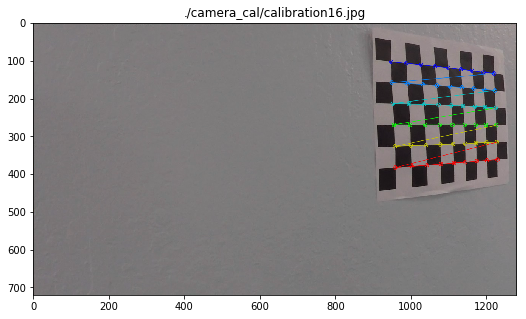

(54, 1, 2) (54, 1, 3)
(17, 54, 1, 2) (17, 54, 1, 3)
1280 720


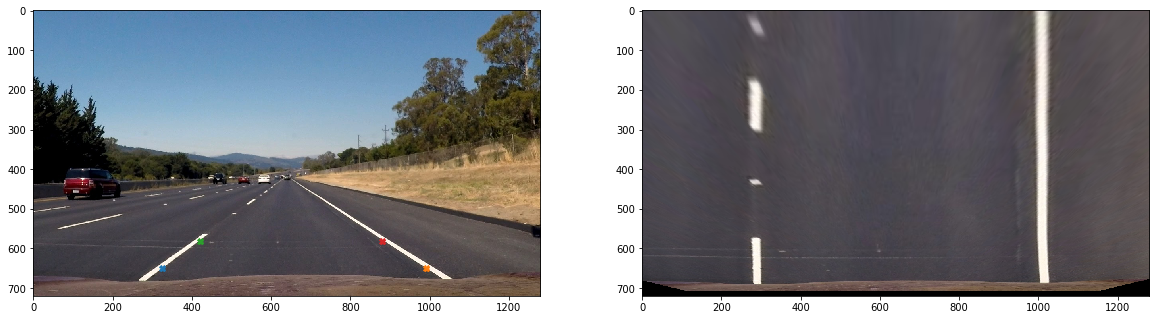

In [20]:
mtx, dist = calibrate_camera()
M, Minv = get_perspective_transform()

In [ ]:
left = Line()
right = Line()
frame_count=0
plt.imshow(process_image(cv2.imread("./test_images/test5.jpg")))

In [96]:
frame_count = 0
DEBUG=False
left = Line()
right = Line()
output = 'clipped.mp4'
clip_in = VideoFileClip("project_video.mp4")
#clip_in = clip_in.subclip(0.0,1.0)
clip_out = clip_in.fl_image(process_image)
%time clip_out.write_videofile(output, audio=False, write_logfile=True, verbose=False)
#print(left.past_coeffs, left.past_measured)



  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:00<04:06,  5.11it/s]

  0%|          | 2/1261 [00:00<04:18,  4.87it/s]

  0%|          | 3/1261 [00:00<04:19,  4.85it/s]

  0%|          | 4/1261 [00:00<04:24,  4.75it/s]

  0%|          | 5/1261 [00:01<04:21,  4.80it/s]

  0%|          | 6/1261 [00:01<04:22,  4.79it/s]

  1%|          | 7/1261 [00:01<04:20,  4.82it/s]

  1%|          | 8/1261 [00:01<04:21,  4.80it/s]

  1%|          | 9/1261 [00:01<04:22,  4.77it/s]

  1%|          | 10/1261 [00:02<04:17,  4.85it/s]

  1%|          | 11/1261 [00:02<04:13,  4.93it/s]

  1%|          | 12/1261 [00:02<04:15,  4.90it/s]

  1%|          | 13/1261 [00:02<04:10,  4.99it/s]

  1%|          | 14/1261 [00:02<04:11,  4.96it/s]

  1%|          | 15/1261 [00:03<04:09,  4.99it/s]

  1%|▏         | 16/1261 [00:03<04:13,  4.92it/s]

  1%|▏         | 17/1261 [00:03<04:11,  4.94it/s]

  1%|▏         | 18/1261 [00:03<04:10,  4.96it/s]

  2%|▏         | 19/1261 [00:03<04:09,  4.99it/

CPU times: user 10min 9s, sys: 5.92 s, total: 10min 15s
Wall time: 5min 33s


In [97]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))